# Forecasting the Breeding Bird Survey

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from macroecotools import richness_in_group, abundance_in_group, obs_pred_rsquare
from bbs_benchmarks import get_data, filter_timeseries, benchmark_predictions, mape

In [5]:
%matplotlib inline

## Initial data setup

In [6]:
min_ts_len = 10
bbs_data = get_data('bbs')
bbs_comm_timeseries = filter_timeseries(bbs_data, ['site_id'], 'year', 1)

## Check number of contiguous time-series 2000-2014 

In [7]:
bbs_data_modern = bbs_data[bbs_data['year'] >= 2000]
bbs_modern_contig_timeseries = filter_timeseries(bbs_data_modern, ['site_id'], 'year', 15)
richness_modern = richness_in_group(bbs_modern_contig_timeseries, ['site_id', 'year'], ['species_id'])
richness_by_site_modern = richness_modern.groupby('site_id')
richness_by_site_modern.ngroups

/home/ethan/anaconda/envs/forecasting/lib/python3.4/site-packages/macroecotools/macroecotools.py:388: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  composition_data['_spid'] = single_spid


657

In [9]:
max(bbs_data['year'])

2014

In [8]:
contig_modern_routes = pd.DataFrame({'contig_modern_routes': list(richness_by_site_modern.groups.keys())})
contig_modern_routes.to_csv('./data/contig_modern_routes.csv', index = False)

## Richness Analysis

In [41]:
richness = richness_in_group(bbs_comm_timeseries, ['site_id', 'year'], ['species_id'])
richness_by_site = richness_by_site_modern#richness.groupby('site_id')

In [42]:
richness_by_site.ngroups
richness.head()

,site_id,year,richness
0,2001,1967,56
1,2001,1969,52
2,2001,1970,52
3,2001,1971,56
4,2001,1972,54


In [21]:
forecast_data = []
for site, site_data in richness_by_site:
    for lag in range(1, min_ts_len):
        forecast_data.append([site, lag] + benchmark_predictions(site_data['year'], site_data['richness'], lag=lag))

forecast_data = pd.DataFrame(forecast_data, columns=['site', 'lag', 'last_yr_rich', 'lag_rich', 'avg_rich'])
forecast_data['forecast_error_avg'] = 100 * (forecast_data['last_yr_rich'] - forecast_data['avg_rich']) / forecast_data['last_yr_rich']
forecast_data['forecast_error_last_yr'] = 100 * (forecast_data['last_yr_rich'] - forecast_data['lag_rich']) / forecast_data['last_yr_rich']

[-1, 9, -50, 50]

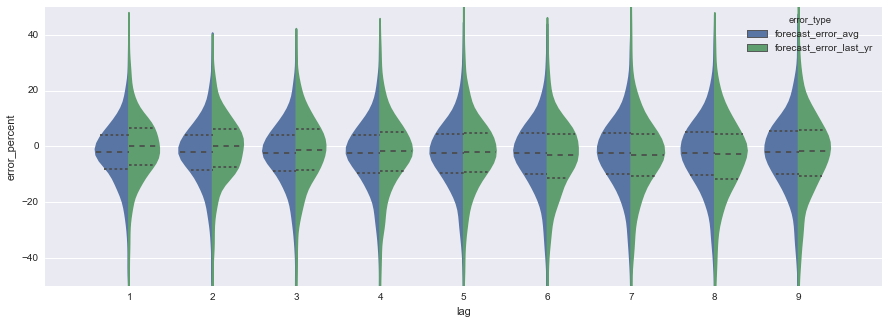

In [22]:
error_data = forecast_data[['lag', 'forecast_error_avg', 'forecast_error_last_yr']]
stacked_error_data = pd.melt(error_data, id_vars=['lag'], value_vars=['forecast_error_avg', 'forecast_error_last_yr'],
                            var_name='error_type', value_name='error_percent')
plt.figure(figsize=[15,5])
sns.violinplot(x="lag", y="error_percent", hue="error_type", data=stacked_error_data, split=True, inner="quart")
plt.axis([-1, min_ts_len -1 , -50, 50])

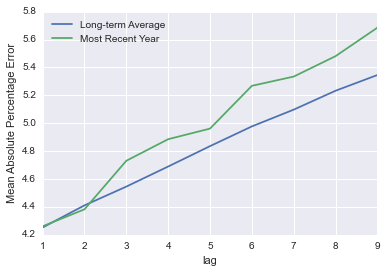

In [23]:
by_lag = forecast_data.groupby('lag')
avg_error_avg = by_lag.apply(lambda x: mape(x['last_yr_rich'], x['avg_rich']))
avg_error_last = by_lag.apply(lambda x: mape(x['last_yr_rich'], x['lag_rich']))
avg_error_avg.plot()
avg_error_last.plot()
plt.ylabel('Mean Absolute Percentage Error')
plt.legend(['Long-term Average', 'Most Recent Year'], loc=2)

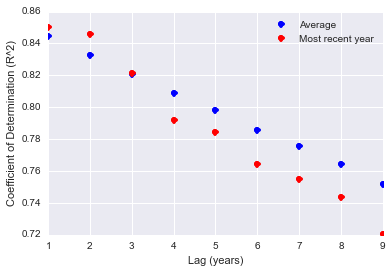

In [24]:
coefdets_avg_rich = []
coefdets_lag_rich = []
lags = []
for lag in range(1, min_ts_len):
    lags.append(lag)
    lag_data = forecast_data[forecast_data['lag'] == lag]
    coefdets_avg_rich.append(obs_pred_rsquare(lag_data['last_yr_rich'], lag_data['avg_rich']))
    coefdets_lag_rich.append(obs_pred_rsquare(lag_data['last_yr_rich'], lag_data['lag_rich']))

plt.plot(lags, coefdets_avg_rich, 'bo')
plt.plot(lags, coefdets_lag_rich, 'ro')
plt.xlabel('Lag (years)')
plt.ylabel('Coefficient of Determination (R^2)')
plt.legend(['Average', 'Most recent year',])

## Population Abundance Analysis

In [ ]:
bbs_pop_timeseries = filter_timeseries(bbs_data, ['site_id', 'species_id'], 'year', 10)
ab_by_pop = bbs_pop_timeseries.groupby(['site_id', 'species_id'])

forecast_data_pop = []
step = 1
for pop, pop_data in ab_by_pop:
    site_id, species_id = pop
    pop_data = pop_data.sort('year')
    last_yr_ab = pop_data['abundance'].iloc[-1]
    other_yrs_ab = pop_data['abundance'].iloc[:-1]
    prev_yr_ab = pop_data.sort('year')['abundance'].iloc[-2]
    avg_ab = np.mean(other_yrs_ab)
    forecast_data_pop.append([site_id, species_id, last_yr_ab, prev_yr_ab, avg_ab])
    step += 1
    if step % 1000 == 0:
        print(step / 200000.0)

forecast_data_pop = pd.DataFrame(forecast_data_pop, columns=['site_id', 'species_id', 'last_yr_ab', 'prev_yr_ab', 'avg_ab'])
coefdet_avg_ab = obs_pred_rsquare(forecast_data_pop['last_yr_ab'], forecast_data_pop['avg_ab'])
coefdet_prev_yr_ab = obs_pred_rsquare(forecast_data_pop['last_yr_ab'], forecast_data_pop['prev_yr_ab'])